### Thesis notebook 4.1. - NOVA IMS

### Data understanding, feature selection and modeling - Non-temporal data

In [1]:
#import necessary modules/libraries
import numpy as np
import scipy
import pandas as pd
import datetime as dt
import warnings
import time
import plotly.express as px

#tqdm to monitor progress
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

#time related features
from datetime import timedelta
from copy import copy, deepcopy

from lightgbm import LGBMModel,LGBMClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer,PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, RFE, RFECV, SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import AgglomerativeClustering , KMeans, DBSCAN

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, ElasticNetCV

from sklearn.datasets import make_classification, load_digits
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, recall_score, classification_report, average_precision_score, precision_recall_curve

In [2]:
#global variables that may come in handy
#course threshold sets the % duration that will be considered (1 = 100%)
duration_threshold = [0.1, 0.25, 0.33, 0.5, 1]

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

#Function designed to deal with multiindex and flatten it
def flattenHierarchicalCol(col,sep = '_'):
    '''converts multiindex columns into single index columns while retaining the hierarchical components'''
    if not type(col) is tuple:
        return col
    else:
        new_col = ''
        for leveli,level in enumerate(col):
            if not level == '':
                if not leveli == 0:
                    new_col += sep
                new_col += level
        return new_col

In [3]:
#imports dataframes

course_programs = pd.read_excel("../Data/Modeling Stage/Nova_IMS_Non_temporal_Datasets.xlsx", 
                                dtype = {
                                    'course_encoding' : object,
                                    'cd_curso' :  object,
                                    'courseid' : object,
                                    'userid' : object},
                               sheet_name = None)

#drop unnamed 0 column
for i in course_programs:
    course_programs[i].drop('Unnamed: 0', axis = 1, inplace = True)

##  Stage: Data understanding Stage

#### INITIAL EXPLORATION, CLEANING & FEATURE ENGINEERING

In [10]:
#get info
columns_copy = ['course_encoding', 'cd_curso', 'semestre', 'courseid', 'userid']
course_programs['Date_threshold_10'][columns_copy] = deepcopy(course_programs['Date_threshold_100'][columns_copy])

In [11]:
#Step1 Checking for missing values
course_programs['Date_threshold_10']

course_encoding cd_curso semestre courseid userid  Number of clicks  \
0                  0     4281       S1   200101    417                71   
1                  0     4281       S1   200101   1042                33   
2                  0     4281       S1   200101   1100                37   
3                  0     4281       S1   200101   2674                14   
4                  0     4281       S1   200101   3802                36   
...              ...      ...      ...      ...    ...               ...   
8281              91     9434       T4   200194   6608                 0   
8282              91     9434       T4   200194   6610                22   
8283              91     9434       T4   200194   6611                17   
8284              91     9434       T4   200194   6655                11   
8285              91     9434       T4   200194   6708                 6   

      Number of sessions  Largest period of inactivity  Total time online  \
0                     16                         10052              100.0   
1                     16                          4377               12.0   
2                     11                          6959               25.0   
3                      2                          3599               21.0   
4                      8                          9581               30.0   
...                  ...                           ...                ...   
8281                   0                             0                0.0   
8282                   6                          9401               21.0   
8283                   7                          9970               66.0   
8284                   4                         10089               13.0   
8285                   3                         10199                0.0   

      Average session duration  Clicks on Course  Resources viewed  \
0                     6.250000                40                12   
1                     0.750000                18                 8   
2                     2.272727                21                 8   
3                    10.500000                 6                 4   
4                     3.750000                26                 3   
...                        ...               ...               ...   
8281                  0.000000                 0                 0   
8282                  3.500000                12                 3   
8283                  9.428571                13                 2   
8284                  3.250000                 7                 2   
8285                  0.000000                 4                 1   

      Discussions viewed  Quizzes started  Assignments submitted  \
0                      0                0                      0   
1                      0                0                      0   
2                      1                0                      0   
3                      0                0                      0   
4                      0                0                      0   
...                  ...              ...                    ...   
8281                   0                0                      0   
8282                   1                0                      0   
8283                   1                0                      0   
8284                   0                0                      0   
8285                   0                0                      0   

      Assignments viewed  Forum posts  exam_mark  final_mark  \
0                      0            0       12.0          12   
1                      0            0       15.0          15   
2                      0            0       16.0          16   
3                      0            0       16.0          16   
4                      0            0       16.0          16   
...                  ...          ...        ...         ...   
8281                   0            0        0.0           0 

In [5]:
len(course_programs['Date_threshold_10'][course_programs['Date_threshold_10'].duplicated(keep=False)])

0

In [6]:
#31748 duplicate rows in total - the rows refer to separate events

dataframe[dataframe.duplicated()]['IsCanceled'].value_counts()

1    17053
0     8849
Name: IsCanceled, dtype: int64

In [7]:
#in total, there seem to be very few missing value
#features whose expected values are numeric look to be numeric. 
#some numeric and object variables may be converted to date-time

dataframe['Country'].fillna('NULL', inplace = True)
dataframe['Children'].fillna(np.mean(dataframe['Children']), inplace = True)

In [8]:
dataframe.describe(include = 'all').T

count unique               top   freq  \
IsCanceled                   79330    NaN               NaN    NaN   
LeadTime                     79330    NaN               NaN    NaN   
ArrivalDateYear              79330    NaN               NaN    NaN   
ArrivalDateMonth             79330     12            August   8983   
ArrivalDateWeekNumber        79330    NaN               NaN    NaN   
ArrivalDateDayOfMonth        79330    NaN               NaN    NaN   
StaysInWeekendNights         79330    NaN               NaN    NaN   
StaysInWeekNights            79330    NaN               NaN    NaN   
Adults                       79330    NaN               NaN    NaN   
Children                     79330    NaN               NaN    NaN   
Babies                       79330    NaN               NaN    NaN   
Meal                         79330      4         BB         62305   
Country                      79330    167               PRT  30960   
MarketSegment                79330      8         Online TA  38748   
DistributionChannel          79330      5             TA/TO  68945   
IsRepeatedGuest              79330    NaN               NaN    NaN   
PreviousCancellations        79330    NaN               NaN    NaN   
PreviousBookingsNotCanceled  79330    NaN               NaN    NaN   
ReservedRoomType             79330      8  A                 62595   
AssignedRoomType             79330      9  A                 57007   
BookingChanges               79330    NaN               NaN    NaN   
DepositType                  79330      3   No Deposit       66442   
Agent                        79330    224                 9  31955   
Company                      79330    208              NULL  75641   
DaysInWaitingList            79330    NaN               NaN    NaN   
CustomerType                 79330      4         Transient  59404   
ADR                          79330    NaN               NaN    NaN   
RequiredCarParkingSpaces     79330    NaN               NaN    NaN   
TotalOfSpecialRequests       79330    NaN               NaN    NaN   
ReservationStatus            79330      3         Check-Out  46228   
ReservationStatusDate        79330    864        2015-10-21   1416   

                                   mean        std   min   25%   50%   75%  \
IsCanceled                      0.41727   0.493111     0     0     0     1   
LeadTime                        109.736    110.949     0    23    74   163   
ArrivalDateYear                 2016.17   0.699181  2015  2016  2016  2017   
ArrivalDateMonth                    NaN        NaN   NaN   NaN   NaN   NaN   
ArrivalDateWeekNumber           27.1774    13.3985     1    17    27    38   
ArrivalDateDayOfMonth           15.7866    8.72845     1     8    16    23   
StaysInWeekendNights           0.795185   0.885026     0     0     1     2   
StaysInWeekNights               2.18296    1.45642     0     1     2     3   
Adults                          1.85098   0.509292     0     2     2     2   
Children                      0.0913698   0.372167     0     0     0     0   
Babies                       0.00494138  0.0843233     0     0     0     0   
Meal                                NaN        NaN   NaN   NaN   NaN   NaN   
Country                             NaN        NaN   NaN   NaN   NaN   NaN   
MarketSegment                       NaN        NaN   NaN   NaN   NaN   NaN   
DistributionChannel                 NaN        NaN   NaN   NaN   NaN   NaN   
IsRepeatedGuest               0.0256145   0.157983     0     0     0     0   
PreviousCancellations         0.0797428   0.415472     0     0     0     0   
PreviousBookingsNotCanceled    0.132371    1.69341     0     0     0     0   
ReservedRoomType                    NaN        NaN   NaN   NaN   NaN   NaN   
AssignedRoomType                    NaN        NaN   NaN   NaN   NaN   NaN   
BookingChanges                 0.187369    0.60862     0     0     0     0   
DepositType                         NaN        NaN   NaN   NaN   NaN   N

In [9]:
#SOME DATA EXPLORATION

array([[<AxesSubplot:title={'center':'IsCanceled'}>,
        <AxesSubplot:title={'center':'LeadTime'}>,
        <AxesSubplot:title={'center':'ArrivalDateYear'}>,
        <AxesSubplot:title={'center':'ArrivalDateWeekNumber'}>],
       [<AxesSubplot:title={'center':'ArrivalDateDayOfMonth'}>,
        <AxesSubplot:title={'center':'StaysInWeekendNights'}>,
        <AxesSubplot:title={'center':'StaysInWeekNights'}>,
        <AxesSubplot:title={'center':'Adults'}>],
       [<AxesSubplot:title={'center':'Children'}>,
        <AxesSubplot:title={'center':'Babies'}>,
        <AxesSubplot:title={'center':'IsRepeatedGuest'}>,
        <AxesSubplot:title={'center':'PreviousCancellations'}>],
       [<AxesSubplot:title={'center':'PreviousBookingsNotCanceled'}>,
        <AxesSubplot:title={'center':'BookingChanges'}>,
        <AxesSubplot:title={'center':'DaysInWaitingList'}>,
        <AxesSubplot:title={'center':'ADR'}>],
       [<AxesSubplot:title={'center':'RequiredCarParkingSpaces'}>,
        <Axe

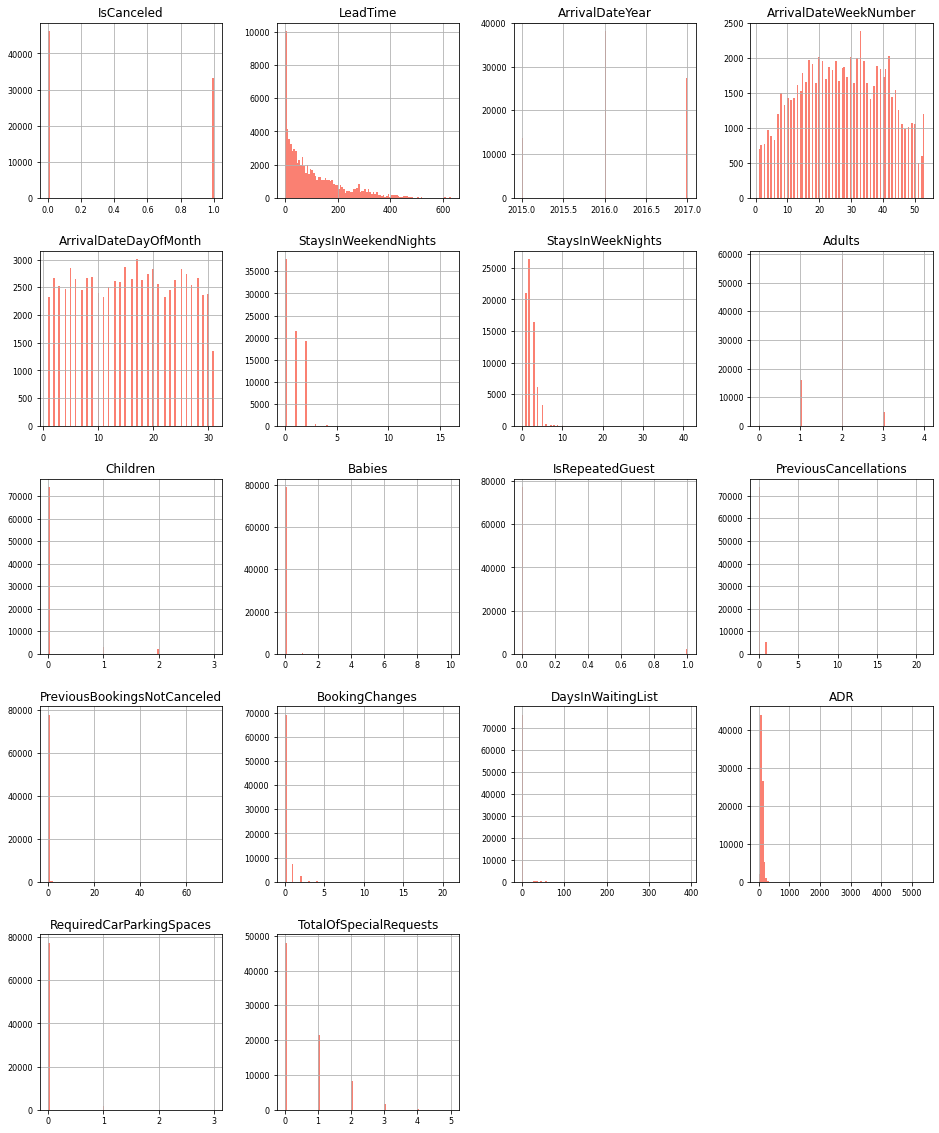

In [10]:
#Plot the distributions of each feature
dataframe.hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8, color = 'salmon')

In [11]:
# Organizar features
target = ['IsCanceled']

numeric_feat = ['LeadTime','ArrivalDateYear','ArrivalDateWeekNumber','ArrivalDateDayOfMonth',
           'StaysInWeekendNights','StaysInWeekNights','Adults','Children','Babies',
           'PreviousCancellations','PreviousBookingsNotCanceled','BookingChanges',
          'Agent','Company','DaysInWaitingList','ADR','RequiredCarParkingSpaces',
          'TotalOfSpecialRequests']

binary_feat = ['IsRepeatedGuest']

categorical_feat = ['ArrivalDateMonth','Meal','Country','MarketSegment','DistributionChannel','ReservedRoomType',
               'AssignedRoomType','DepositType','CustomerType','ReservationStatus']

date = ['ReservationStatusDate']

In [12]:
#Data Quality Report for Continuous Features

def DescribeContinuousFeatures(Continuous_Features, dataset):
    Continuous_Head = ['Count', 'Missing Values (%)', 'Cardinality', 'Minimum', '1st Qrt.', 'Mean', 'Median', '3rd Qrt.', 'Maximum', 'Std. Dev.']
    Continuous_Describe = pd.DataFrame(index=Continuous_Features, columns=Continuous_Head)
    Continuous_Describe.index.name = 'Feature Name'
    columns = dataset[Continuous_Features]

#Total Number of Instances
    Continuous_Describe[Continuous_Head[0]] = columns.count()

#Percentage of instances that has Missing Values (sabendo à partida que nenhuma variável contínua tem missings)
    Continuous_Describe[Continuous_Head[1]] = columns.isnull().sum() * 100 / len(dataset)
    
#Cardinality of each feature (cardinality measures the number of Distinct Values)
    Continuous_Describe[Continuous_Head[2]] = columns.nunique()

#Minimum Value
    Continuous_Describe[Continuous_Head[3]] = columns.min()

#1ST Quartile
    Continuous_Describe[Continuous_Head[4]] = columns.quantile(0.25)

#Mean
    Continuous_Describe[Continuous_Head[5]] = round(columns.mean(), 2)

#Median
    Continuous_Describe[Continuous_Head[6]] = columns.median()

#3rd Quartile
    Continuous_Describe[Continuous_Head[7]] = columns.quantile(0.75)

#Maximum Value
    Continuous_Describe[Continuous_Head[8]] = columns.max()

#Standard Deviation
    Continuous_Describe[Continuous_Head[9]] = round(columns.std(),2)
    
    return Continuous_Describe

DescribeContinuousFeatures(numeric_feat,dataframe)

Count  Missing Values (%)  Cardinality  \
Feature Name                                                          
LeadTime                     79330                 0.0          453   
ArrivalDateYear              79330                 0.0            3   
ArrivalDateWeekNumber        79330                 0.0           53   
ArrivalDateDayOfMonth        79330                 0.0           31   
StaysInWeekendNights         79330                 0.0           14   
StaysInWeekNights            79330                 0.0           29   
Adults                       79330                 0.0            5   
Children                     79330                 0.0            5   
Babies                       79330                 0.0            5   
PreviousCancellations        79330                 0.0           10   
PreviousBookingsNotCanceled  79330                 0.0           73   
BookingChanges               79330                 0.0           21   
Agent                        79330                 0.0          224   
Company                      79330                 0.0          208   
DaysInWaitingList            79330                 0.0          115   
ADR                          79330                 0.0         5405   
RequiredCarParkingSpaces     79330                 0.0            4   
TotalOfSpecialRequests       79330                 0.0            6   

                                 Minimum  1st Qrt.     Mean  Median  3rd Qrt.  \
Feature Name                                                                    
LeadTime                               0      23.0   109.74    74.0     163.0   
ArrivalDateYear                     2015    2016.0  2016.17  2016.0    2017.0   
ArrivalDateWeekNumber                  1      17.0    27.18    27.0      38.0   
ArrivalDateDayOfMonth                  1       8.0    15.79    16.0      23.0   
StaysInWeekendNights                   0       0.0     0.80     1.0       2.0   
StaysInWeekNights                      0       1.0     2.18     2.0       3.0   
Adults                                 0       2.0     1.85     2.0       2.0   
Children                               0       0.0     0.09     0.0       0.0   
Babies                                 0       0.0     0.00     0.0       0.0   
PreviousCancellations                  0       0.0     0.08     0.0       0.0   
PreviousBookingsNotCanceled            0       0.0     0.13     0.0       0.0   
BookingChanges                         0       0.0     0.19     0.0       0.0   
Agent                                  1       NaN      NaN     NaN       NaN   
Company                                8       NaN      NaN     NaN       NaN   
DaysInWaitingList                      0       0.0     3.23     0.0       0.0   
ADR                                    0      79.2   105.30    99.9     126.0   
RequiredCarParkingSpaces               0       0.0     0.02     0.0       0.0   
TotalOfSpecialRequests                 0       0.0     0.55     0.0       1.0   

                                 Maximum  Std. Dev.  
Feature Name                                         
LeadTime                             629     110.95  
ArrivalDateYear                     2017       0.70  
ArrivalDateWeekNumber                 53      13.40  
ArrivalDateDayOfMonth                 31       8.73  
StaysInWeekendNights                  16       0.89  
StaysInWeekNights                     41       1.46  
Adults                                 4       0.51  
Children                               3       0.37  
Babies                                10       0.08  
PreviousCancellations                 21       0.42  
PreviousBookingsNotCanceled           72       1.69  
BookingChanges                        21       0.61  
Agent                               NULL        NaN  
Company                             NULL        NaN  
DaysInWaitingList                    391      20.87  
ADR                                 5400      43.60  
RequiredCarPark

In [13]:
#hidden ofor faster computation

#perform a very simple pairplot
g = sns.PairGrid(dataframe[numeric_feat], height = 10, corner = True)

#frequency histogram on diagonal
g.map_diag(sns.histplot, color = 'grey', stat = 'frequency', kde = True)

#regplot is a scatter with regression line
g.map_offdiag(sns.regplot, fit_reg=True, x_jitter=.1, color = 'salmon',  marker = 'x')

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

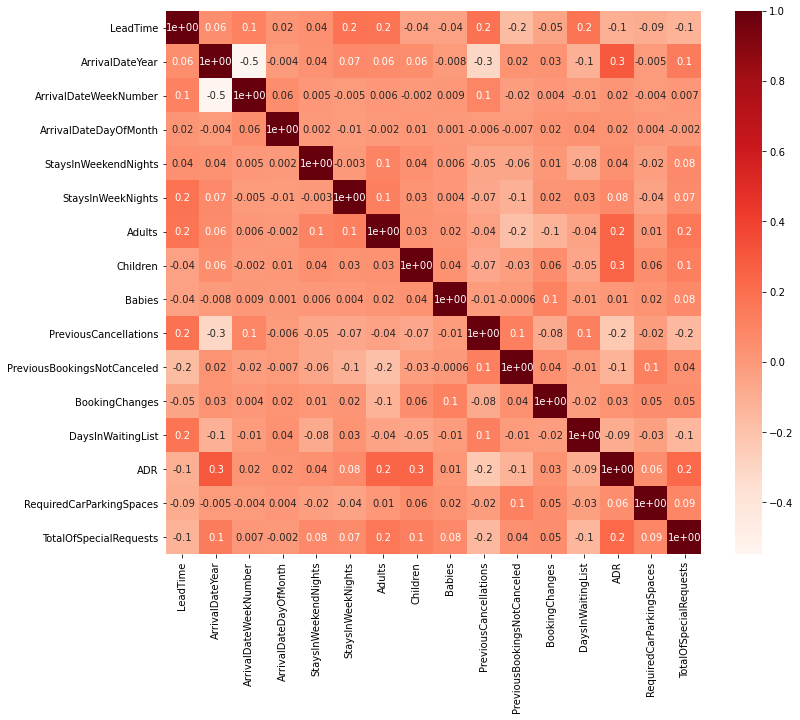

In [14]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
    
cor_spearman = dataframe[numeric_feat].corr(method = 'spearman')
cor_heatmap(cor_spearman)

In [15]:
#Data Quality Report for Categorical Features

def DescribeCategoricalFeatures(Categorical_Features, dataset):
    Categorical_Head = ['Count', 'Missing Values (%)', 'Cardinality', 'Mode', 'Mode frequency', 'Mode (%)',\
                        '2nd Mode', '2nd Mode frequency', '2nd Mode (%)']

    Categorical_Describe = pd.DataFrame(index=Categorical_Features, columns=Categorical_Head)
    Categorical_Describe.index.name = 'Feature Name'
    columns = dataset[Categorical_Features]
    
    #Total Number of Instances
    Categorical_Describe[Categorical_Head[0]] = columns.count()
    missings = []
    for col in columns:
        missings.append(len(dataset[dataset[col]=='?']) * 100/ len(dataset))
    #Percentage of instances that has Missing Values 
    Categorical_Describe[Categorical_Head[1]] = missings
    
    #Cardinality of each feature (cardinality measures the number of Distinct Values)
    Categorical_Describe[Categorical_Head[2]] = columns.nunique()
    
    Categorical_Describe[Categorical_Head[3]] = columns.mode().T
    
    Categorical_Describe[Categorical_Head[4]] = columns.describe().T['freq']
    
    Categorical_Describe[Categorical_Head[5]] = columns.describe().T['freq']/columns.describe().T['count']
    
    snd_modes = []
    snd_modes_freq = []
    for col in columns:
        snd_modes.append(columns[col].value_counts().index[1])
        snd_modes_freq.append(columns[col].value_counts()[1])
        
    Categorical_Describe[Categorical_Head[6]] = snd_modes
    
    Categorical_Describe[Categorical_Head[7]] = snd_modes_freq
    
    Categorical_Describe[Categorical_Head[8]] = Categorical_Describe[Categorical_Head[7]]/columns.describe().T['count']
    
    return Categorical_Describe

DescribeCategoricalFeatures(categorical_feat,dataframe)

Count  Missing Values (%)  Cardinality              Mode  \
Feature Name                                                                    
ArrivalDateMonth     79330                 0.0           12            August   
Meal                 79330                 0.0            4         BB          
Country              79330                 0.0          167               PRT   
MarketSegment        79330                 0.0            8         Online TA   
DistributionChannel  79330                 0.0            5             TA/TO   
ReservedRoomType     79330                 0.0            8  A                  
AssignedRoomType     79330                 0.0            9  A                  
DepositType          79330                 0.0            3   No Deposit        
CustomerType         79330                 0.0            4         Transient   
ReservationStatus    79330                 0.0            3         Check-Out   

                    Mode frequency  Mode (%)          2nd Mode  \
Feature Name                                                     
ArrivalDateMonth              8983  0.113236               May   
Meal                         62305   0.78539         SC          
Country                      30960  0.390268               FRA   
MarketSegment                38748  0.488441     Offline TA/TO   
DistributionChannel          68945  0.869091            Direct   
ReservedRoomType             62595  0.789046  D                  
AssignedRoomType             57007  0.718606  D                  
DepositType                  66442  0.837539   Non Refund        
CustomerType                 59404  0.748821   Transient-Party   
ReservationStatus            46228   0.58273          Canceled   

                     2nd Mode frequency 2nd Mode (%)  
Feature Name                                          
ArrivalDateMonth                   8232     0.103769  
Meal                              10564     0.133165  
Country                            8804     0.110979  
MarketSegment                     16747     0.211106  
DistributionChannel                6780    0.0854658  
ReservedRoomType                  11768     0.148342  
AssignedRoomType                  14983     0.188869  
DepositType                       12868     0.162208  
CustomerType                      17333     0.218492  
ReservationStatus                 32186     0.405723

In [16]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="skyblue")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.xticks(rotation='vertical')
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="skyblue")
    plt.xticks(rotation='vertical')
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()

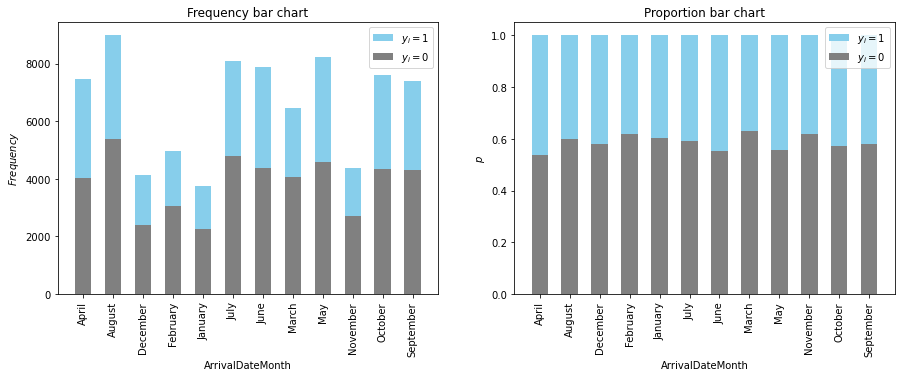

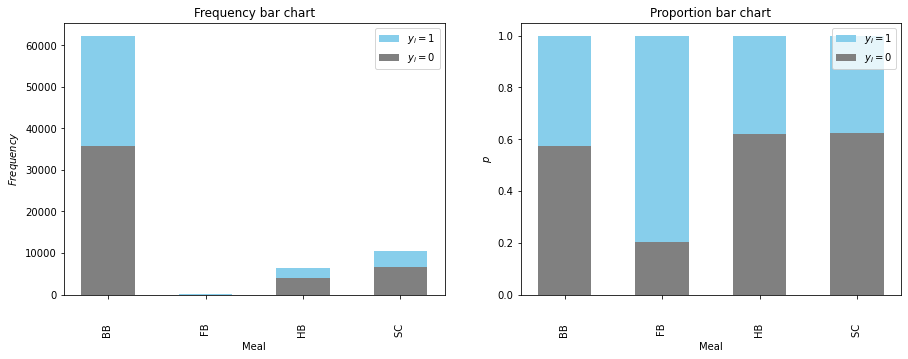

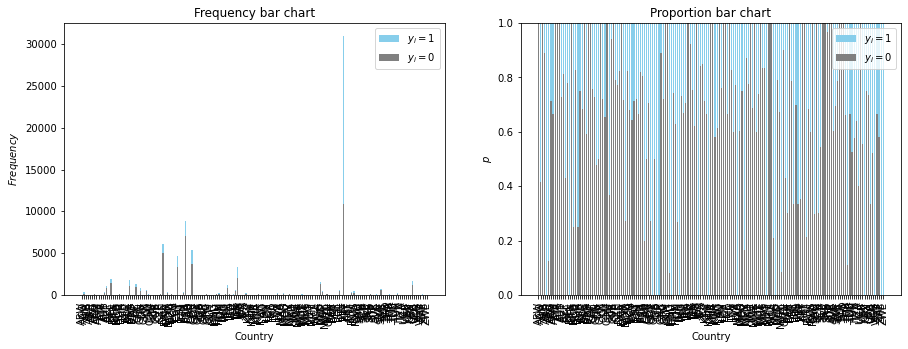

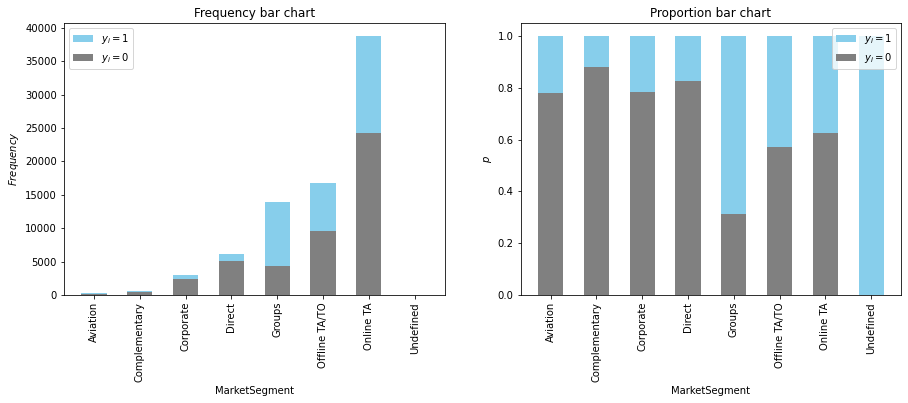

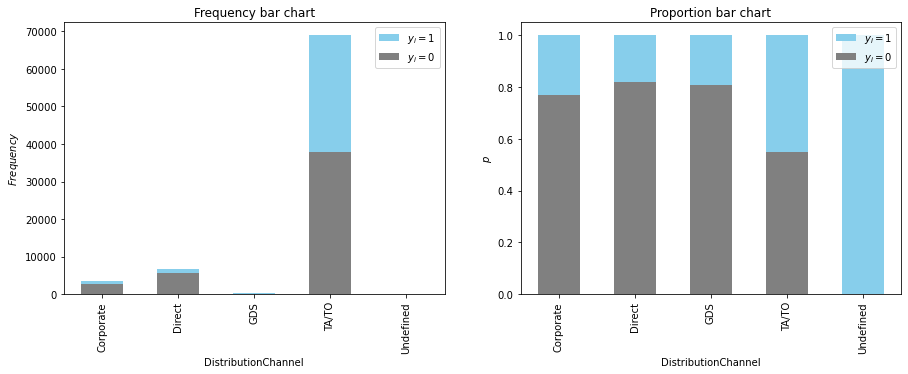

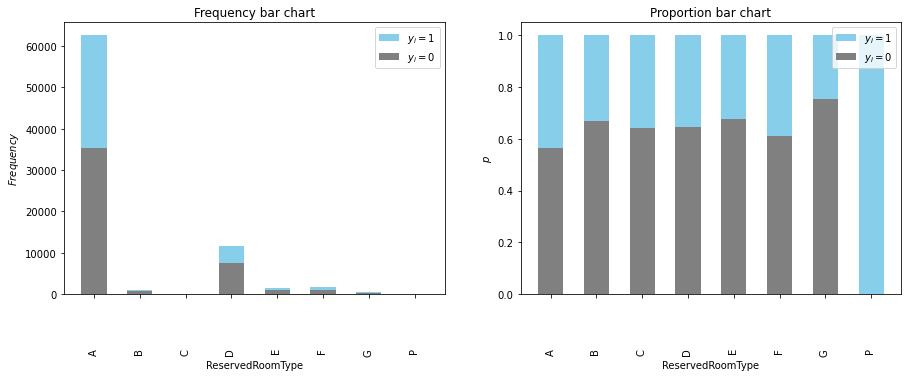

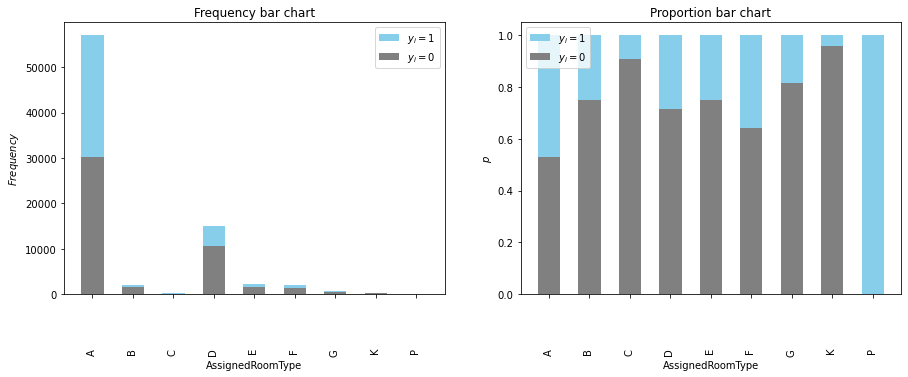

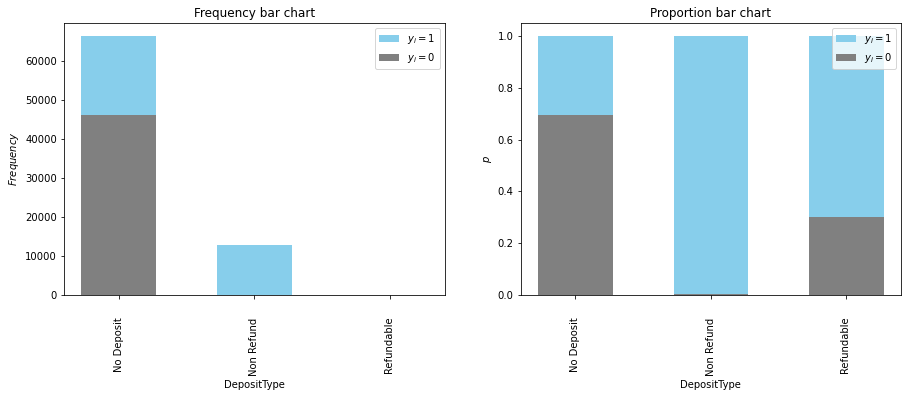

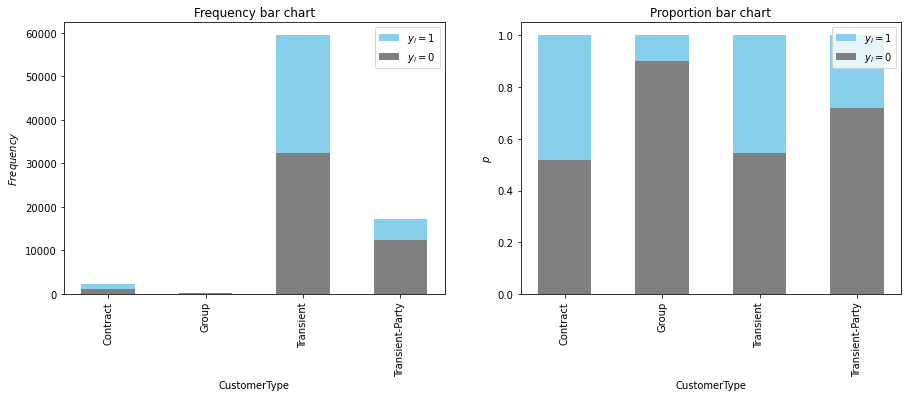

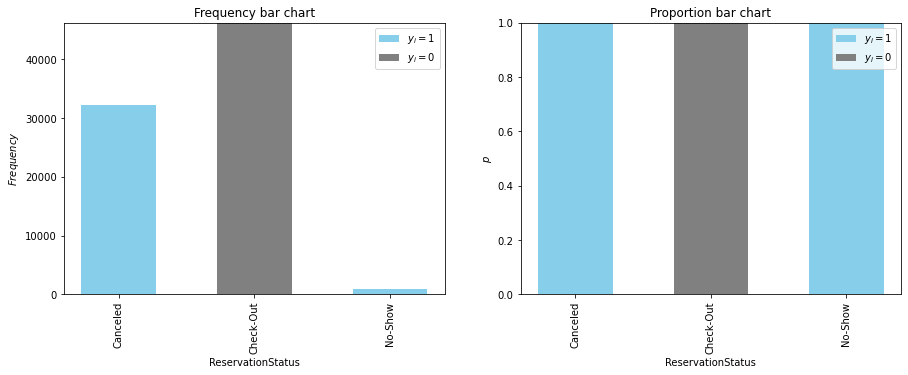

In [17]:
for var in categorical_feat:
    bar_charts_categorical(dataframe, var, 'IsCanceled')

In [18]:
country_cancel = dataframe['Country'].value_counts().rename("Occurrences").to_frame()
country_cancel['canceled'] = dataframe[dataframe['IsCanceled']==1]['Country'].value_counts()
country_cancel = country_cancel.fillna(0)
country_cancel['%canceled'] = country_cancel['canceled']/country_cancel['Occurrences']

fig = px.choropleth(country_cancel, locations=country_cancel.index,
                    color='%canceled', # lifeExp is a column of gapminder
                    hover_name=country_cancel.index, # column to add to hover information
                    color_continuous_scale=px.colors.diverging.Temps,
                   title='Country % of cancelations')
fig.show()

### Immediate observations

Very low correlations throughout among metric features.
Still need to verify what to do concerning outliers.

## Functions to Call later

In [19]:
#ENCODERS
def encode_categorical(dataset):
    encoded_df = dataset.copy()

    #months
    months = {'January':1,'February':2,'March':3,'April':4,'May':5,
             'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    encoded_df['ArrivalDateMonth'] = encoded_df['ArrivalDateMonth'].map(months)
    
    #countries
    other_countries = list(filter(lambda w: w not in ['PRT','ITA','GBR','FRA','DEU','ESP'], list(encoded_df['Country'].unique())))
    encoded_df['Country'] = encoded_df['Country'].replace(other_countries,'Other')
    countries = {'PRT':1,'FRA':2,'DEU':3,'GBR':4,'ESP':5,'ITA':6,'Other':7}
    encoded_df['Country'] = encoded_df['Country'].map(countries)
    
    #To one-hot
    list_to_dummify =['Meal','DepositType','CustomerType','MarketSegment']
    
    dummies = pd.get_dummies(encoded_df[list_to_dummify])
    encoded_df = encoded_df.join(dummies)
    encoded_df.drop(columns = list_to_dummify,axis=1,inplace=True)
    
    #ordinal    
    #confirmar agent e company
    enc = OrdinalEncoder()
    to_encode = ["ReservedRoomType","AssignedRoomType",'DistributionChannel']
    encoded_df[to_encode] = enc.fit_transform(encoded_df[to_encode])
        
        
        
        
    return encoded_df

In [20]:
def feature_selection_table(dataset):

    feature_df = dataset.copy()

    X = feature_df.drop(['IsCanceled'],axis=1)
    y = feature_df['IsCanceled']
    num_feats=len(X.columns)
    X_norm = MinMaxScaler().fit_transform(X)

    #RFE
    rfe_selector = RFE(estimator=DecisionTreeClassifier(), step=2)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()

    #RFECV
    rfecv_selector = RFECV(estimator=DecisionTreeClassifier(), step=3, cv=5, scoring='f1_weighted')
    rfecv_selector = rfecv_selector.fit(X_norm, y)
    rfecv_support = rfecv_selector.support_
    rfecv_feature = X.loc[:,rfecv_support].columns.tolist()

    #Logistic regression
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

    #RandomForest 
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()


    #LGBMClassifier
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

    #Lasso
    reg = LassoCV(random_state=123) 
    reg.fit(X=X,y=y)
    lasso_coef = pd.Series(reg.coef_,index = X.columns)

    #Ridge
    ridge = RidgeCV()
    ridge.fit(X=X,y=y)
    coef_ridge = pd.Series(ridge.coef_,index = X.columns)

    #Elastic 
    elast = ElasticNetCV(cv=5, random_state=123)
    elast.fit(X, y)
    elast_coef = pd.Series(elast.coef_,index = X.columns)

    # put all selection together
    feature_selection_df = pd.DataFrame({'Feature':X.columns, 'RFE':rfe_support,'RFECV':rfecv_support, 'Logistics':embeded_lr_support,
                                        'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support, 'Lasso':lasso_coef != 0, 'Ridge':coef_ridge != 0, 'Elastic':elast_coef != 0})
    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total'] , ascending=False)
    feature_selection_df.set_index('Feature',inplace=True)
    feature_selection_df
    
    return feature_df,feature_selection_df

In [21]:
def normalize(dataset,scaler):
    
    if scaler == 'MinMax':
        pt = MinMaxScaler()
    elif scaler == 'Standard':
        pt = StandardScaler()
    elif scaler == 'Robust':
        pt = RobustScaler()
    elif scaler == 'Quantile':
        pt = QuantileTransformer()
    else:
        pt = PowerTransformer(method='yeo-johnson')
    
    data = pt.fit_transform(dataset)
    
    # convert the array back to a dataframe
    normalized_df = pd.DataFrame(data,columns=dataset.columns)
    return normalized_df

# Starting data preparation:


## Start by Calling the Funtions

In [22]:
#Dropping non relevant features

data_prep_df = dataframe.drop(columns =['ReservationStatus','ReservationStatusDate','ArrivalDateYear'])
#data_prep_df['Agent'] = data_prep_df['Agent'].replace(NULL,0)
data_prep_df['Company'] = data_prep_df['Company'].str.replace('NULL','0').astype(int)
data_prep_df['Agent'] = data_prep_df['Agent'].str.replace('NULL','0').astype(int)

In [23]:
X = data_prep_df.drop(['IsCanceled'],axis=1)
y = data_prep_df['IsCanceled']

In [24]:
encoded_df = encode_categorical(data_prep_df)

In [25]:
#Feature Selection Table cited in report

feature_df,feature_selection_df = feature_selection_table(encoded_df)
feature_selection_df

RFE  RFECV  Logistics  Random Forest  \
Feature                                                                
LeadTime                       True   True       True           True   
TotalOfSpecialRequests         True   True       True           True   
StaysInWeekNights              True   True       True           True   
ADR                            True   True       True           True   
ArrivalDateWeekNumber          True   True      False           True   
Agent                          True   True      False           True   
ReservedRoomType               True   True       True          False   
DepositType_No Deposit         True   True       True           True   
BookingChanges                 True   True       True          False   
AssignedRoomType               True   True       True          False   
Country                        True   True      False           True   
PreviousCancellations          True   True       True           True   
Company                       False   True      False          False   
DistributionChannel           False   True      False          False   
DepositType_Non Refund        False  False       True           True   
MarketSegment_Online TA        True   True      False          False   
ArrivalDateDayOfMonth          True   True      False           True   
ArrivalDateMonth               True   True      False           True   
CustomerType_Transient         True   True      False          False   
CustomerType_Transient-Party  False   True      False          False   
RequiredCarParkingSpaces       True   True       True          False   
DaysInWaitingList             False   True      False          False   
PreviousBookingsNotCanceled    True   True       True          False   
Adults                         True   True      False          False   
StaysInWeekendNights           True   True      False          False   
Meal_BB                        True   True      False          False   
Meal_HB                       False   True      False          False   
Meal_SC                       False   True      False          False   
IsRepeatedGuest               False   True      False          False   
Babies                        False   True      False          False   
MarketSegment_Groups          False   True      False          False   
CustomerType_Contract         False   True      False          False   
Meal_FB                       False  False       True          False   
Children                      False   True      False          False   
MarketSegment_Aviation        False   True      False          False   
MarketSegment_Offline TA/TO   False   True      False          False   
MarketSegment_Corporate       False   True      False          False   
MarketSegment_Direct          False   True      False          False   
CustomerType_Group            False  False      False          False   
MarketSegment_Complementary   False  False      False          False   
DepositType_Refundable        False  False      False          False   
MarketSegment_Undefined       False  False      False          False   

                              LightGBM  Lasso  Ridge  Elastic  Total  
Feature                                                               
LeadTime                          True   True   True     True      8  
TotalOfSpecialRequests            True   True   True     True      8  
StaysInWeekNights                 True   True   True     True      8  
ADR                               True   True   True     True      8  
ArrivalDateWeekNumber             True   True   True     True      7  
Agent                             True   True   True     True      7  
ReservedRoomType                  True   True   True     True      7  
DepositType_No Deposit           False   True   True     True      7  
BookingChanges                   False   True   True     True      6  
AssignedRoomType                 False   True   True     True      6  
Country    

In [26]:
final_feature_dataset = feature_df[feature_selection_df.loc[feature_selection_df['Total'] >3].index.tolist()]
#general normalization
normalized_dataset = normalize(final_feature_dataset,'Quantile')

In [27]:
X = normalized_dataset

In [28]:
X

LeadTime  TotalOfSpecialRequests  StaysInWeekNights       ADR  \
0      0.121121                0.000000           0.494995  0.000000   
1      0.549049                0.739239           0.906406  0.227227   
2      0.461962                0.739239           0.906406  0.147147   
3      0.562062                0.925926           0.906406  0.227227   
4      0.589590                0.739239           0.494995  0.227227   
...         ...                     ...                ...       ...   
79325  0.251251                0.000000           0.965966  0.462930   
79326  0.596597                0.925926           0.965966  0.989132   
79327  0.315315                0.998498           0.965966  0.903323   
79328  0.617618                0.000000           0.965966  0.551051   
79329  0.823824                0.925926           0.991992  0.886887   

       ArrivalDateWeekNumber     Agent  ReservedRoomType  \
0                   0.493493  0.228729          0.000000   
1                   0.493493  0.507007          0.000000   
2                   0.493493  0.507007          0.000000   
3                   0.493493  0.507007          0.000000   
4                   0.493493  0.507007          0.000000   
...                      ...       ...               ...   
79325               0.686687  0.997998          0.000000   
79326               0.686687  0.507007          0.961461   
79327               0.686687  0.507007          0.877377   
79328               0.686687  0.929930          0.000000   
79329               0.686687  0.507007          0.000000   

       DepositType_No Deposit       BookingChanges  AssignedRoomType  ...  \
0                              1.0             0.0          0.000000  ...   
1                              1.0             0.0          0.000000  ...   
2                              1.0             0.0          0.000000  ...   
3                              1.0             0.0          0.000000  ...   
4                              1.0             0.0          0.000000  ...   
...                            ...             ...               ...  ...   
79325                          1.0             0.0          0.000000  ...   
79326                          1.0             0.0          0.948448  ...   
79327                          1.0             0.0          0.840340  ...   
79328                          1.0             0.0          0.000000  ...   
79329                          1.0             0.0          0.000000  ...   

       MarketSegment_Online TA  ArrivalDateDayOfMonth  ArrivalDateMonth  \
0                          0.0               0.000000          0.540040   
1                          1.0               0.000000          0.540040   
2                          1.0               0.000000          0.540040   
3                          1.0               0.000000          0.540040   
4                          1.0               0.046046          0.540040   
...                        ...                    ...               ...   
79325                      0.0               0.967968          0.647648   
79326                      1.0               1.000000          0.647648   
79327                      1.0               1.000000          0.647648   
79328                      1.0               1.000000          0.647648   
79329                      1.0               0.938438          0.647648   

       CustomerType_Transient  CustomerType_Transient-Party  \
0                         1.0                           0.0   
1                         1.0                           0.0   
2                         1.0                           0.0   
3                         1.0                           0.0   
4                         1.0                           0.0   
...                       ...                           ...   
79325                     1.0                           0.0   
79326                     1.0                           0.0   
79327                     1.

# MODEL TESTING & SELECTION

We will make a split between between train and test. As we will use cross validation (repeated_Stratified_k_fold)



In [29]:
#train_test_split to get 20% of data as test

X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                  y,
                                                  test_size = 0.20,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=y)

In [30]:
#run desired model
def run_model(model_name, X, y):
    
    ###STANDALONE MODELS
    if model_name == 'KNN':
        #Manhattan distance, which should work better for high dimensional datasets
        #weights to attribute higher weight to closer neighbors; seems to improve score highly
        model = KNeighborsClassifier(n_neighbors=10, p = 1, weights='distance').fit(X, y) #
    if model_name == 'LR':
        model = LogisticRegression().fit(X, y) #
    if model_name == 'NB': 
        model = GaussianNB().fit(X, y)
    if model_name == 'BNB': #
        model = BernoulliNB().fit(X, y)
    if model_name == 'MNB': #
        model = MultinomialNB().fit(X, y)
    if model_name == 'NN': #
        model = MLPClassifier(alpha=0.01, hidden_layer_sizes = (5,5), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', verbose = 0, learning_rate_init = 0.02, batch_size = 1000, max_iter = 1000).fit(X, y)
    if model_name == 'DT':
        model = DecisionTreeClassifier(criterion='entropy', max_depth = 14, min_samples_split= 50).fit(X, y) #max_features=6,
    if model_name == 'SVM': #
        model = svm.SVC(C=0.05, degree=2, gamma='scale', kernel='rbf').fit(X, y)
    
    ###ENSEMBLES
    if model_name == 'RF':
        model = RandomForestClassifier(max_depth = 11, random_state = 5, n_estimators=500, min_samples_leaf = 3).fit(X, y) #max_features=6, #max_depth é super imp para reduzir overfitting! #min_samples_lead highly reduces overfitting!
    if model_name == 'Bagg_NN':
        model = BaggingClassifier(base_estimator = MLPClassifier(alpha=0.01, hidden_layer_sizes = (5,5), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', verbose = 0, learning_rate_init = 0.02, batch_size = 1000, max_iter = 1000), n_estimators = 5, random_state = 5).fit(X, y)
    if model_name == 'AdaBoost':
        model = AdaBoostClassifier(n_estimators = 95, learning_rate = 0.8, random_state = 5).fit(X, y) #importante que GSearchCV em DT maximizado!
    if model_name == 'GBoost':
        model = GradientBoostingClassifier(n_estimators=175, learning_rate=0.1, random_state=15).fit(X, y)
    if model_name == 'ExtraTree':
        model = ExtraTreesClassifier(n_estimators=175, criterion='entropy', max_depth = 14, min_samples_split= 50).fit(X, y)
    return model

In [31]:
#averages scores of each run (for the present model) in each iteration of Repeated 10-fold CV that has been called
def avg_score(method,X,y, model_name):
    
    f1micro_train = []
    f1micro_val = []
    precision_train = []
    precision_val = []
    recall_train = []
    recall_val = []
    timer = []
    cm_holder = []
    averaged_confusion_matrix=None
    
    for train_index, val_index in method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        begin = time.perf_counter()
        model = run_model(model_name, X_train, y_train)
        end = time.perf_counter()
        
        labels_train = model.predict(X_train)
        labels_val = model.predict(X_val)
        
        f1micro_train.append(f1_score(y_train, labels_train, average='micro'))
        f1micro_val.append(f1_score(y_val, labels_val, average='micro'))
        
        precision_train.append(precision_score(y_train, labels_train))
        precision_val.append(precision_score(y_val, labels_val))
        
        recall_train.append(recall_score(y_train, labels_train))
        recall_val.append(recall_score(y_val, labels_val))
        
        timer.append(end-begin)
        
        if model_name == 'GBoost':
            cm_holder.append(confusion_matrix(y_val, labels_val))
        
    model = run_model(model_name, X,y)
    labels_test = model.predict(X_test)
    
    f1micro_test = f1_score(y_test, labels_test, average='micro')
    precision_test = precision_score(y_test, labels_test)
    recall_test = recall_score(y_test, labels_test)
    
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_f1_train = round(np.mean(f1micro_train),3)
    avg_f1_val = round(np.mean(f1micro_val),3)
    avg_f1_test = round(np.mean(f1micro_test),3)
    avg_precision_train = round(np.mean(precision_train),3)
    avg_precision_val = round(np.mean(precision_val),3)
    avg_precision_test = round(precision_test,3)
    avg_recall_train = round(np.mean(recall_train),3)
    avg_recall_val = round(np.mean(recall_val),3)
    avg_recall_test = round(recall_test,3)
    
    std_time = round(np.std(timer),3)
    std_f1_train = round(np.std(f1micro_train),3)
    std_f1_val = round(np.std(f1micro_test),3)
    std_precision_train = round(np.std(precision_train),3)
    std_precision_val = round(np.std(precision_val),3)
    std_recall_train = round(np.std(recall_train),3)
    std_recall_val = round(np.std(recall_val),3)
    
    averaged_confusion_matrix = np.mean(cm_holder, axis = 0).round(2)
    
    #from sklearn.metrics import cohen_kappa_score
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_f1_train) + '+/-' + str(std_f1_train), str(avg_f1_val) + '+/-' + str(std_f1_val), str(avg_f1_test), str(avg_precision_train) + '+/-' + str(std_precision_train), str(avg_precision_val) + '+/-' + str(std_precision_val), str(avg_precision_test), str(avg_recall_train) + '+/-' + str(std_recall_train), str(avg_recall_val) + '+/-' + str(std_recall_val), str(avg_recall_test), averaged_confusion_matrix


In [32]:
###STANDALONE MODELS:

#runs each Repeated (10) 10-fold Cross-Validation in all tested models by calling function avg_score and prints resutls with multiple metrics for each

method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = 15)

results_KNN = avg_score(method_cv, X_train_val, y_train_val, 'KNN')
results_LR = avg_score(method_cv, X_train_val, y_train_val, 'LR')
results_NB = avg_score(method_cv, X_train_val, y_train_val, 'NB')
results_BNB = avg_score(method_cv, X_train_val, y_train_val, 'BNB')
results_MNB = avg_score(method_cv, X_train_val, y_train_val, 'MNB')
results_NN = avg_score(method_cv, X_train_val, y_train_val, 'NN')
results_DT = avg_score(method_cv, X_train_val, y_train_val, 'DT')
resultsSVM = avg_score(method_cv, X_train_val, y_train_val, 'SVM')


In [33]:
results_models = [results_KNN, results_LR, results_NB, results_BNB, results_MNB, results_NN, results_DT, resultsSVM]

f1micro_train = []
f1micro_val = []
f1micro_test = []

precision_train = []
precision_val = []
precision_test = []

recall_train = []
recall_val = []
recall_test = []

times = []

#organizes data for futher plotting
for i, model in enumerate(results_models):
    
    f1micro_train.append(results_models[i][1])
    f1micro_val.append(results_models[i][2])
    f1micro_test.append(results_models[i][3])
    
    precision_train.append(results_models[i][4])
    precision_val.append(results_models[i][5])
    precision_test.append(results_models[i][6])
    
    recall_train.append(results_models[i][7])
    recall_val.append(results_models[i][8])
    recall_test.append(results_models[i][9])
    
    times.append(results_models[i][0])
    
results = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['KNN', 'LR', 'NB', 'BNB', 'MNB', 'NN', 'DT', 'SVM'])

df

KNN             LR  \
Train Accuracy (F1 Score micro)         0.995+/-0.0  0.803+/-0.001   
Validation Accuracy (F1 Score micro)    0.864+/-0.0    0.803+/-0.0   
Test Accuracy (F1 Score micro)                0.869          0.804   
Precision Train                       0.997+/-0.001  0.836+/-0.001   
Precision Validation                  0.851+/-0.007  0.836+/-0.008   
Precision Test                                0.851          0.833   
Recall Train                          0.992+/-0.001  0.656+/-0.001   
Recall Validation                     0.816+/-0.007  0.656+/-0.009   
Recall Test                                   0.831          0.663   
Time                                   1.59+/-0.063  0.452+/-0.009   

                                                 NB            BNB  \
Train Accuracy (F1 Score micro)       0.619+/-0.003    0.766+/-0.0   
Validation Accuracy (F1 Score micro)    0.619+/-0.0    0.767+/-0.0   
Test Accuracy (F1 Score micro)                0.621          0.769   
Precision Train                       0.526+/-0.002  0.924+/-0.001   
Precision Validation                  0.526+/-0.004  0.924+/-0.006   
Precision Test                                0.527          0.928   
Recall Train                          0.897+/-0.003   0.48+/-0.001   
Recall Validation                     0.897+/-0.006   0.48+/-0.009   
Recall Test                                   0.897          0.485   
Time                                   0.03+/-0.001  0.029+/-0.002   

                                                MNB             NN  \
Train Accuracy (F1 Score micro)         0.765+/-0.0  0.841+/-0.004   
Validation Accuracy (F1 Score micro)    0.765+/-0.0     0.84+/-0.0   
Test Accuracy (F1 Score micro)                0.766          0.838   
Precision Train                       0.954+/-0.001  0.846+/-0.023   
Precision Validation                  0.954+/-0.006  0.846+/-0.024   
Precision Test                                0.951          0.874   
Recall Train                          0.459+/-0.001  0.758+/-0.026   
Recall Validation                     0.459+/-0.009  0.757+/-0.026   
Recall Test                                   0.464          0.714   
Time                                  0.012+/-0.001  6.229+/-1.332   

                                                 DT             SVM  
Train Accuracy (F1 Score micro)       0.859+/-0.001     0.818+/-0.0  
Validation Accuracy (F1 Score micro)    0.848+/-0.0     0.818+/-0.0  
Test Accuracy (F1 Score micro)                0.845            0.82  
Precision Train                       0.868+/-0.006   0.863+/-0.001  
Precision Validation                  0.853+/-0.008   0.862+/-0.007  
Precision Test                                0.839           0.857  
Recall Train                          0.782+/-0.007   0.672+/-0.001  
Recall Validation                     0.769+/-0.011   0.671+/-0.009  
Recall Test                                   0.779           0.682  
Time                                  0.237+/-0.007  111.9+/-10.917

In [34]:
def plt_bar(models, f1micro_train, f1micro_val, f1micro_test):
    
    #Creates a figure and a set of subplots
    fig, ax = plt.subplots(figsize = (20, 10))

    #sets style of the plot to increase readibility
    sns.set_style(style="whitegrid")

    #set width of bar
    barwidth = 0.3

    #set position of bar on X axis
    pos_train = np.arange(len(f1micro_test))
    pos_val = np.arange(len(f1micro_test))+0.3
    pos_test = np.arange(len(f1micro_test))+0.6

    #makes the plot
    plt.bar(pos_train, f1micro_train, color='dodgerblue', width=barwidth, edgecolor='white', label='Train')
    plt.bar(pos_val, f1micro_val, color='steelblue', width=barwidth, edgecolor='white', label='Validation')
    plt.bar(pos_test, f1micro_test, color='skyblue', width=barwidth, edgecolor='white', label='Test')

    #sets x, y labels
    ax.set(xlabel = 'Model', ylabel = 'Accuracy')

    #sets x ticks locations and designation
    ax.set_xticks((pos_train+pos_val+pos_test)/3)
    ax.set_xticklabels(models, rotation='vertical')

    #personalizes yticks to inrease readibility of data in the plot
    ax.set_yticks(np.arange(0, 1, 0.1))

    #ads title to the plot
    plt.title('10-fold Repeated Cross-Validation Results', fontsize = 14)

    #removes box to make the plot prettier
    plt.box(on=None)

    #Creates (pretty) legend
    plt.legend(frameon=False)

    #shows plot
    plt.show()

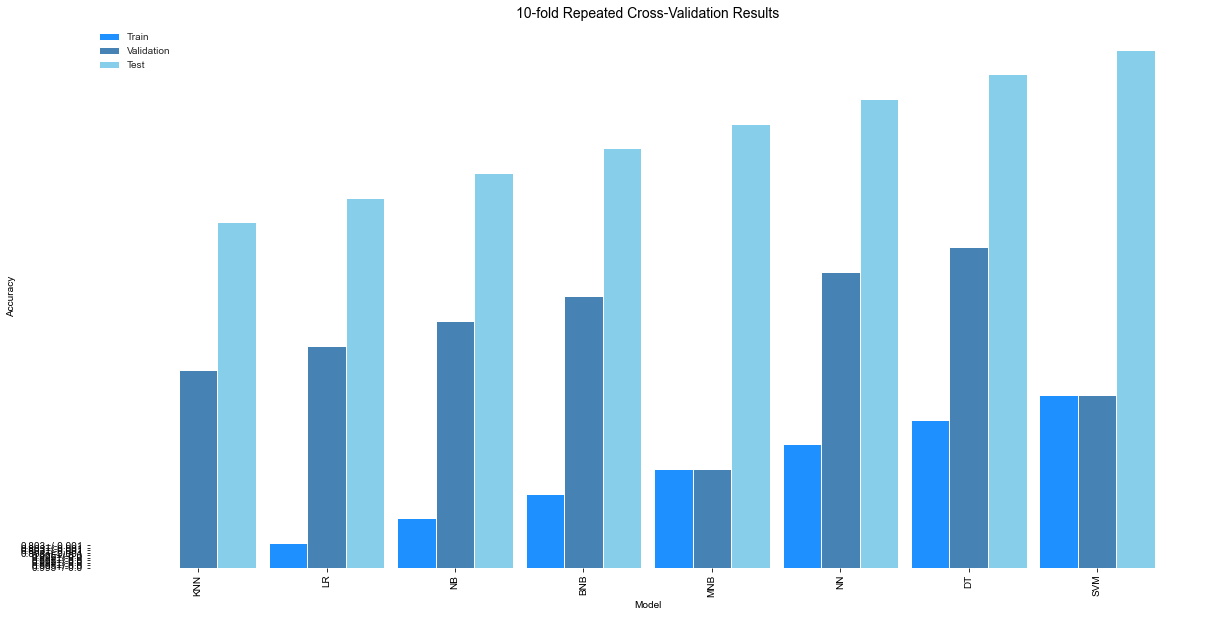

In [35]:
models = ['KNN', 'LR', 'NB', 'BNB', 'MNB', 'NN', 'DT', 'SVM']
plt_bar(models, f1micro_train, f1micro_val, f1micro_test)

In [36]:
def plot_roc_pr(models, X, y):  
    sns.set_style(style="whitegrid")
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute False postive rate, and True positive rate
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:,1])
    #Calculate AUC
        auc = roc_auc_score(y,model.predict_proba(X)[:,1])
    #Plot
        plt.plot(fpr, tpr, label='%s ROC (area = %0.4f)' % (m['label'], auc))
    #Makes it pretty!
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC Curve Test')
    plt.legend(loc="lower right", frameon=False)
    plt.show()

    
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute Precision and Recall
        precision, recall, _ = precision_recall_curve(y, model.predict_proba(X)[:,1])
    #Calculate AP
        ap = average_precision_score(y, model.predict_proba(X)[:,1])
    #Plot
        plt.plot(recall, precision, label='%s AP (area = %0.4f)' % (m['label'], ap))
    #Makes it pretty!
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Positive Predictive Value)')
    plt.ylabel('Precision (True Positive Rate)')
    plt.title('Precision-Recall Curve Test')
    plt.legend(loc="lower left", frameon=False)
    plt.show()

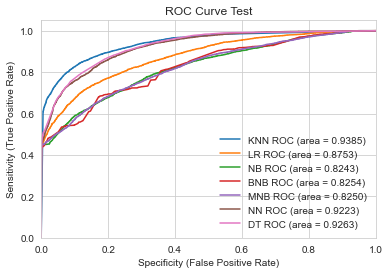

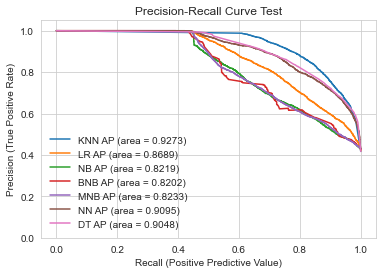

In [37]:
plt.figure()

# Add models to list of models to incorporte in ROC curve
models = [{'label': 'KNN', 'model': run_model('KNN', X_train_val, y_train_val),},
          {'label': 'LR', 'model': run_model('LR', X_train_val, y_train_val),},
          {'label': 'NB','model': run_model('NB', X_train_val, y_train_val),},
          {'label': 'BNB', 'model': run_model('BNB', X_train_val, y_train_val),},
          {'label': 'MNB', 'model': run_model('MNB', X_train_val, y_train_val),},
          {'label': 'NN', 'model': run_model('NN', X_train_val, y_train_val),},
          {'label': 'DT', 'model': run_model('DT', X_train_val, y_train_val),},] 
            #SVM not included coz there's no probs!
    
plot_roc_pr(models, X_test, y_test)

Given the fact that Decision Trees were a standalone model that yielded the best results (along with Neural Networks and Logistic Regression), we decided to try out a few ensemble methods that have Decision Trees as base learners:

In [38]:
method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = 15)

results_Bag_NN = avg_score(method_cv, X_train_val, y_train_val, 'Bagg_NN')
results_RF = avg_score(method_cv, X_train_val, y_train_val, 'RF')
results_AdaBoost = avg_score(method_cv, X_train_val, y_train_val, 'AdaBoost')
results_GBoost = avg_score(method_cv, X_train_val, y_train_val, 'GBoost')
results_Xtra = avg_score(method_cv, X_train_val, y_train_val, 'ExtraTree')

In [39]:
results_models = [results_Bag_NN, results_RF, results_AdaBoost, results_GBoost, results_Xtra]

f1micro_train = []
f1micro_val = []
f1micro_test = []

precision_train = []
precision_val = []
precision_test = []

recall_train = []
recall_val = []
recall_test = []

times = []

#organizes data for futher plotting
for i, model in enumerate(results_models):
    
    f1micro_train.append(results_models[i][1])
    f1micro_val.append(results_models[i][2])
    f1micro_test.append(results_models[i][3])
    
    precision_train.append(results_models[i][4])
    precision_val.append(results_models[i][5])
    precision_test.append(results_models[i][6])
    
    recall_train.append(results_models[i][7])
    recall_val.append(results_models[i][8])
    recall_test.append(results_models[i][9])
    
    times.append(results_models[i][0])
    
results = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['Bagg_NN', 'RF', 'AdaBoost', 'GBoost', 'ExtraTree'])

print('Averaged Confusion Matrix for XtraTree:\n', results_models[4][10])

df 

Averaged Confusion Matrix for XtraTree:
 nan


Bagg_NN              RF  \
Train Accuracy (F1 Score micro)        0.847+/-0.002   0.857+/-0.001   
Validation Accuracy (F1 Score micro)     0.845+/-0.0     0.852+/-0.0   
Test Accuracy (F1 Score micro)                 0.848           0.851   
Precision Train                         0.86+/-0.009     0.9+/-0.001   
Precision Validation                   0.858+/-0.012   0.895+/-0.006   
Precision Test                                 0.859           0.888   
Recall Train                           0.756+/-0.011    0.74+/-0.001   
Recall Validation                      0.754+/-0.014   0.731+/-0.008   
Recall Test                                     0.76           0.734   
Time                                  30.572+/-3.794  14.996+/-0.181   

                                           AdaBoost         GBoost  \
Train Accuracy (F1 Score micro)       0.823+/-0.001  0.851+/-0.001   
Validation Accuracy (F1 Score micro)    0.822+/-0.0    0.849+/-0.0   
Test Accuracy (F1 Score micro)                0.824          0.847   
Precision Train                       0.843+/-0.001  0.862+/-0.002   
Precision Validation                  0.842+/-0.007  0.858+/-0.006   
Precision Test                                0.838          0.852   
Recall Train                          0.709+/-0.002  0.766+/-0.002   
Recall Validation                     0.708+/-0.008  0.763+/-0.008   
Recall Test                                   0.715          0.766   
Time                                   3.36+/-0.017  11.88+/-0.346   

                                          ExtraTree  
Train Accuracy (F1 Score micro)       0.853+/-0.001  
Validation Accuracy (F1 Score micro)    0.849+/-0.0  
Test Accuracy (F1 Score micro)                0.848  
Precision Train                       0.899+/-0.001  
Precision Validation                  0.895+/-0.007  
Precision Test                                0.888  
Recall Train                          0.729+/-0.003  
Recall Validation                     0.723+/-0.008  
Recall Test                                   0.727  
Time                                  5.347+/-0.209

## Comparative ROC and Precision Recall Plot of Best Performing Models

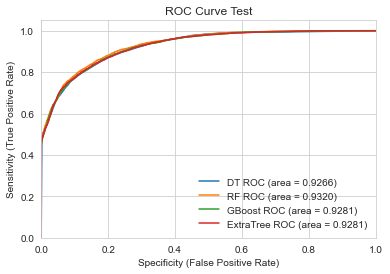

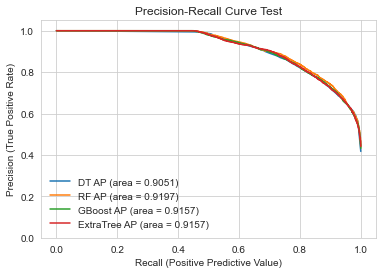

In [41]:
# Add models to list of models to incorporte in ROC curve
models = [{'label': 'DT', 'model': run_model('DT', X_train_val, y_train_val),},
          {'label': 'RF', 'model': run_model('RF', X_train_val, y_train_val),},
          {'label': 'GBoost', 'model': run_model('GBoost', X_train_val, y_train_val),},
          {'label': 'ExtraTree', 'model': run_model('ExtraTree', X_train_val, y_train_val),}]


plot_roc_pr(models, X_test, y_test)

We finish by understanding that ExtraTrees Classifiers looks to be most suitable model. In the next Notebook, we will look to optimize our ExtraTrees Classification.